In [181]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore') #(action='once')

# Helper function to get neighbors
def get_Von_Neumann_neighbourhood(x, y, grid, grid_size):
    left = (x-1) % grid_size, y
    right = (x+1) % grid_size, y
    bottom = x, (y-1) % grid_size
    top = x, (y+1) % grid_size
    return [grid[left], grid[right], grid[bottom], grid[top]]

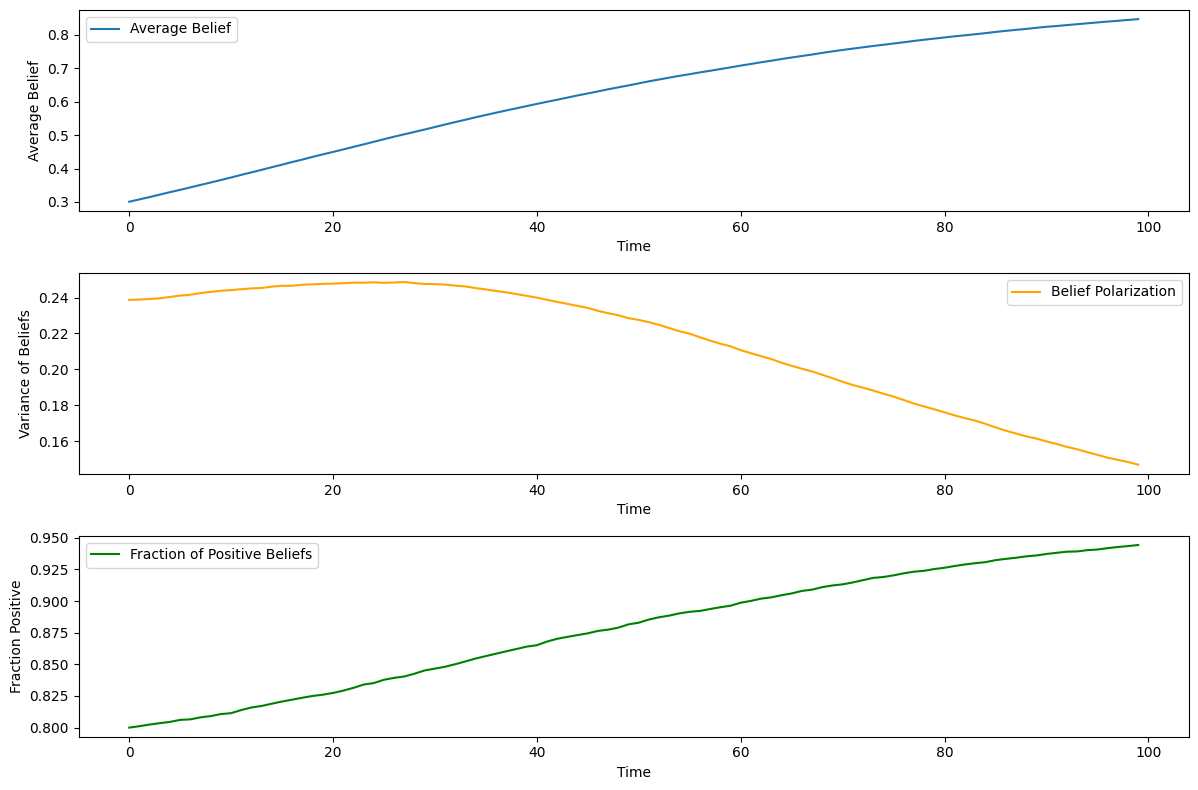

In [182]:
# Set parameters according to Task 1
N = 10000
grid_size = int(np.sqrt(N))
c_max = 0.5
p_plus = 0.8

# Initialize beliefs grid
beliefs_grid = np.zeros((grid_size, grid_size))

# Initialize convincing power grid
convincing_powers = np.random.uniform(0, c_max, (grid_size, grid_size))

# Assign initial beliefs
positive_fraction = int(N * p_plus)
negative_fraction = N - positive_fraction
beliefs_grid.flat[:positive_fraction] = np.random.uniform(0, 1, positive_fraction)
beliefs_grid.flat[positive_fraction:] = np.random.uniform(-1, 0, negative_fraction)
np.random.shuffle(beliefs_grid.flat)

# Simulation
timesteps = 100

average_beliefs = []
belief_variances = []
positive_belief_fractions = []

for i in range(timesteps):
    # Record global observables
    average_beliefs.append(np.mean(beliefs_grid))
    belief_variances.append(np.var(beliefs_grid))
    positive_belief_fractions.append(np.mean(beliefs_grid > 0))

   # Update beliefs
    for _ in range(N // 10):  # Update 10% of the population
        x, y = np.random.randint(0, grid_size, size=2)
        neighbourhood_b = get_Von_Neumann_neighbourhood(x, y, beliefs_grid, grid_size)
        neighbourhood_c = get_Von_Neumann_neighbourhood(x, y, convincing_powers, grid_size)
        beliefs_grid[x, y] += np.mean([b * c for b, c in zip(neighbourhood_b, neighbourhood_c)])
        beliefs_grid[x, y] = np.clip(beliefs_grid[x, y], -1, 1)

# Visualization
time = np.arange(timesteps)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, average_beliefs, label='Average Belief')
plt.xlabel('Time')
plt.ylabel('Average Belief')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, belief_variances, label='Belief Polarization', color='orange')
plt.xlabel('Time')
plt.ylabel('Variance of Beliefs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, positive_belief_fractions, label='Fraction of Positive Beliefs', color='green')
plt.xlabel('Time')
plt.ylabel('Fraction Positive')
plt.legend()

plt.tight_layout()
plt.show()